## Deep Neural Network model with Label Encoding PCA
*Summary:* In this notebook, we use a DNN model using PCA analysis. We use label encoding for the categorical variables and reduce the dimensionality from a total of 196 features to 18 features, that retain the explanation of 95% of the variance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

In [16]:
df = pd.concat([train, test]).reset_index(drop=True)
attack_cat_df = df['attack_cat']
df = df.drop(columns=['id', 'attack_cat', 'label'], axis=1)

# get numeric column names without label column
num_cols = df._get_numeric_data().columns

# subract numeric columns from all columns to get categorical columns 
cat_cols = list(set(df.columns) - set(num_cols))

print(f"Numerical features: {len(num_cols)}\nCategorical features: {len(cat_cols)}")

Numerical features: 39
Categorical features: 3


In [17]:
from sklearn.preprocessing import MinMaxScaler

df[cat_cols] = df[cat_cols].astype('category')
for cat in cat_cols:
    df[cat] = df[cat].cat.codes

df[cat_cols]

,proto,state,service
0,119,5,0
1,119,5,0
2,119,5,0
3,119,5,0
4,119,5,0
...,...,...,...
257668,119,5,2
257669,113,4,0
257670,119,5,2
257671,119,5,2


In [25]:
# apply min-max scaler that scales the variables in the range [0-1]
scl = MinMaxScaler()
df = scl.fit_transform(df)

In [31]:
from sklearn.decomposition import PCA

# apply principal component analysis
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_df)

pca_df

,0,1,2,3,4,5,6,7,8,9,10
0,-0.782517,-0.019278,-0.434279,-0.143849,-0.143722,-0.033623,0.053112,-0.000026,0.068036,-0.075005,0.023751
1,-0.775704,-0.034400,-0.453373,-0.119990,-0.200415,-0.045221,0.130624,0.140866,0.302216,-0.057119,-0.099826
2,-0.794653,-0.036226,-0.421886,-0.142256,-0.174053,-0.039984,0.092364,0.078309,0.138112,0.009949,-0.038697
3,-0.796393,-0.035295,-0.404071,-0.137547,-0.159845,-0.036886,0.078807,0.052981,0.119915,-0.016534,-0.022682
4,-0.779061,-0.043580,-0.425183,-0.102118,-0.205160,-0.045878,0.145981,0.171237,0.388044,-0.082036,-0.133514
...,...,...,...,...,...,...,...,...,...,...,...
257668,-1.006850,-0.187477,0.439006,0.083193,0.021705,0.005563,0.009638,-0.014605,0.018156,-0.078166,-0.018483
257669,1.145673,-0.577834,-0.089745,-0.236487,0.166209,0.049098,0.256501,-0.197499,-0.016913,0.008683,0.029062
257670,-0.843997,-0.061730,-0.169242,-0.048666,-0.118811,-0.027163,0.062178,0.038015,-0.024258,-0.082422,0.047073
257671,-1.064012,-0.231827,0.651510,0.123628,0.070601,0.016876,-0.013917,-0.035156,0.040819,-0.078037,-0.029928


In [35]:
from sklearn.model_selection import train_test_split

y = pd.get_dummies(attack_cat_df)
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((172640, 11), (85033, 11), (172640, 10), (85033, 10))

### Tensorflow model

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [37]:
model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(10, activation='softmax', use_bias=True)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 86,794
Trainable params: 86,794
Non-traina

In [38]:
model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')

monitor_val_acc = EarlyStopping(monitor='loss', patience=10)
callbacks=[PlotLossesKeras()]

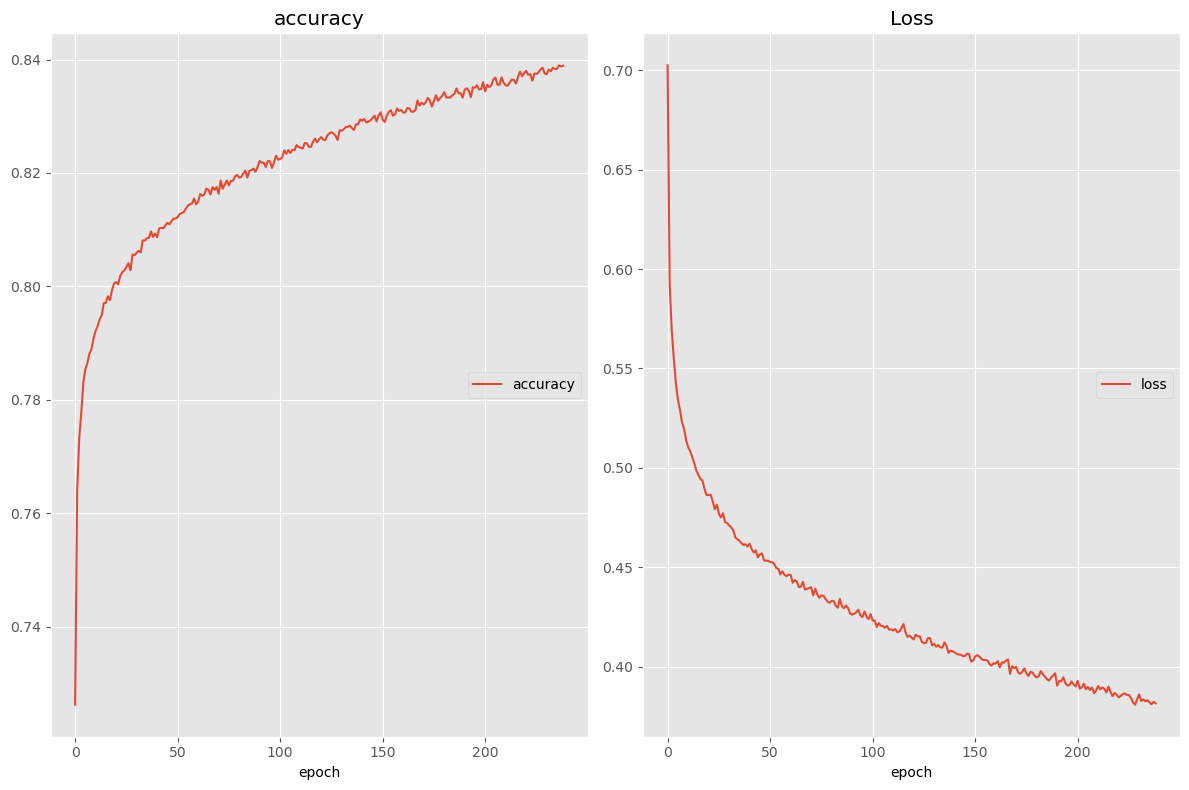

accuracy
	accuracy         	 (min:    0.726, max:    0.839, cur:    0.839)
Loss
	loss             	 (min:    0.381, max:    0.703, cur:    0.381)


In [39]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, callbacks=[PlotLossesKeras(), monitor_val_acc], shuffle=1000, verbose=0)

In [40]:
model.evaluate(X_test, y_test)

2658/2658 [==============================] - 4s 2ms/step - loss: 0.5616 - accuracy: 0.8131


[0.5615522861480713, 0.8130608201026917]